## THIS REQUIRES THE BIGGEST SESH AVAILABLE

# Kinetic Energy Mean-Transient Decomposition

Decomposing the kinetic energy into time-mean and transient components.

## Theory

For a hydrostatic ocean model, like MOM5, the relevant kinetic energy per unit mass is 

$$ {\rm KE} = \frac{1}{2} (u^2 + v^2).$$

The vertical velocity component, $w$, does not appear in the mechanical energy budget. It is very much subdominant. But more fundamentally, it simply does not appear in the mechanical energy buget for a hydrostatic ocean. 

For a non-steady fluid, we can define the time-averaged kinetic energy as the __total kinetic energy__, TKE

$$ {\rm TKE} = \left< {\rm KE} \right > {\stackrel{\rm{def}}{=}} \frac{1}{T} \int_0^T \frac{1}{2} \left( u^2 + v^2 \right)\,\mathrm{d}t.$$

It is useful to decompose the velocity into time-mean and time-varying components, e.g.,

$$ u = \bar{u} + u'.$$

The __mean kinetic energy__ is the energy associated with the mean flow

$$ {\rm MKE} = \frac{1}{2} \left( \bar{u}^2 + \bar{v}^2 \right) $$

The kinetic energy of the time varying component is the __eddy kinetic energy__, EKE. This quantity can be obtained by 
substracting the velocity means and calculating the kinetic energy of the 
perturbation velocity quantities.

$$ {\rm EKE} =  \overline{ \frac{1}{2} \left[ \left(u - \overline{u}\right)^2 + \left(v - \overline{v}\right)^2 \right] } $$
                                 
MKE and EKE partition the total kinetic energy

$${\rm TKE} = {\rm MKE} + {\rm EKE}.$$


## Calculation


We start by importing some useful packages.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc

from cosima_cookbook import distributed as ccd

import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm
import xarray as xr
import cmocean.cm as cmocean
import matplotlib.ticker as ticker
from dask.distributed import Client

In [2]:
# from tqdm import tqdm_notebook

Import cartopy to plot maps:

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as feature

land_50m = feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=0.2)

Start up a dask cluster.

In [4]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


2023-05-16 22:16:09,968 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/83889477.gadi-pbs/dask-worker-space/worker-0l98cqhj', purging
2023-05-16 22:16:09,968 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/83889477.gadi-pbs/dask-worker-space/worker-k1xixhoc', purging
2023-05-16 22:16:09,969 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/83889477.gadi-pbs/dask-worker-space/worker-c59uauk_', purging
2023-05-16 22:16:09,969 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/83889477.gadi-pbs/dask-worker-space/worker-nuzcczbu', purging
2023-05-16 22:16:09,969 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/83889477.gadi-pbs/dask-worker-space/worker-ej0icljg', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45665,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:41201,Total threads: 4
Dashboard: /proxy/34525/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:44267,


Create a database session and select an experiment. Here we choose an experiment which has daily velocities saved for the Southern Ocean.

In [5]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt = '01deg_jra55v13_ryf9091'
iaf_cycle = '01deg_jra55v140_iaf'
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

In [6]:
lat_slice  = slice(-67, -64)
lon_slice  = slice(-255, -246)

depth_slice = 500
u = cc.querying.getvar(iaf_cycle,'u',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 daily').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice).sel(st_ocean=depth_slice,method = 'nearest')

v = cc.querying.getvar(iaf_cycle,'v',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 daily').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice).sel(st_ocean=depth_slice,method = 'nearest')

2023-05-16 22:21:46,588 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


In [7]:
u_mean = u.mean('time')
v_mean = v.mean('time')

In [8]:
u_transient = u - u_mean
v_transient = v - v_mean

In [10]:
dz=1
EKE = (0.5*(u_transient**2 + v_transient**2)*dz)

In [11]:
EKE_m=EKE.mean('time')

In [14]:
%%time
EKE_m = EKE_m.compute()

2023-05-16 22:36:17,277 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-05-16 22:36:38,010 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-05-16 22:36:59,069 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


CPU times: user 1min 44s, sys: 5.64 s, total: 1min 50s
Wall time: 2min


In [15]:
lat_slice  = slice(-67, -64)
lon_slice  = slice(-255, -246)

#depth_slice = 500
u_surf = cc.querying.getvar(iaf_cycle3,'usurf',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 daily').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

v_surf = cc.querying.getvar(iaf_cycle3,'vsurf',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 daily').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

2023-05-16 22:38:06,039 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-05-16 22:38:07,544 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-05-16 22:38:07,686 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-05-16 22:38:07,972 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-05-16 22:38:08,131 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-05-16 22:38:08,386 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-05-16 22:38:08,418 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-05-16 22:38:08,675 - distributed.utils_perf - WARNING - full garbage collections took

In [16]:
u_surf_mean = u_surf.mean('time')
v_surf_mean = v_surf.mean('time')

In [17]:
u_surf_transient = u_surf - u_surf_mean
v_surf_transient = v_surf - v_surf_mean

In [18]:
dz=1
EKE_surf = (0.5*(u_surf_transient**2 + v_surf_transient**2)*dz)

In [20]:
%%time
EKE_surf_m = EKE_surf.compute()

2023-05-16 22:40:22,205 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-05-16 22:40:22,326 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-05-16 22:40:22,369 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-05-16 22:40:31,666 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-05-16 22:40:34,970 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-05-16 22:40:39,205 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-05-16 22:40:51,384 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-05-16 22:40:55,148 - distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 3min 50s, sys: 8.47 s, total: 3min 58s
Wall time: 4min 44s


In [22]:
lat_slice  = slice(-67, -64)
lon_slice  = slice(-255, -246)

depth_slice = slice(0,500)
u2 = cc.querying.getvar(iaf_cycle,'u',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 daily').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice).sel(st_ocean=depth_slice)

v2 = cc.querying.getvar(iaf_cycle,'v',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 daily').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice).sel(st_ocean=depth_slice)

2023-05-16 22:47:14,379 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-05-16 22:47:16,209 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-05-16 22:47:16,240 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-05-16 22:47:16,288 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-05-16 22:47:16,308 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-05-16 22:47:16,360 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-05-16 22:47:16,376 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-05-16 22:47:16,557 - distributed.utils_perf - WARNING - full garbage collections took

In [23]:
u_int = u2
v_int = v2

In [24]:
u_int_mean = u_int.mean('time')
v_int_mean = v_int.mean('time')

## Eddy Kinetic Energy

We calculate the transient component of the velocity field and then compute the EKE:


$$ {\rm EKE} =  \overline{ \frac{1}{2} \left[ \left(u - \overline{u}\right)^2 + \left(v - \overline{v}\right)^2 \right] }. $$

## Eddy Kinetic Energy

We calculate the transient component of the velocity field and then compute the EKE:


$$ {\rm EKE} =  \overline{ \frac{1}{2} \left[ \left(u - \overline{u}\right)^2 + \left(v - \overline{v}\right)^2 \right] }. $$

In [25]:
u_int_transient = u_int - u_int_mean
v_int_transient = v_int - v_int_mean

In [26]:
dz = np.gradient(v_int_transient.st_ocean)[:, np.newaxis, np.newaxis]
EKE_int = (0.5*(u_int_transient**2 + v_int_transient**2)*dz).sum('st_ocean')

In [27]:
EKE_int_m=EKE_int.mean('time')

In [28]:
%%time
EKE_int_m = EKE_int_m.compute()

2023-05-16 22:58:41,535 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-05-16 22:59:34,510 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-05-16 22:59:47,864 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-05-16 23:01:25,261 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-05-16 23:01:38,078 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-05-16 23:01:45,611 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-05-16 23:02:21,296 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-05-16 23:03:02,836 - distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 12min 57s, sys: 20.9 s, total: 13min 18s
Wall time: 14min 32s


In [35]:
EKE_surf_m = EKE_surf_m.mean('time')

### PLOT 

In [36]:
# cut the data BOX 1
lon_slice  = slice(-255, -240)
lat_slice  = slice(-67, -63)

# topography data:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

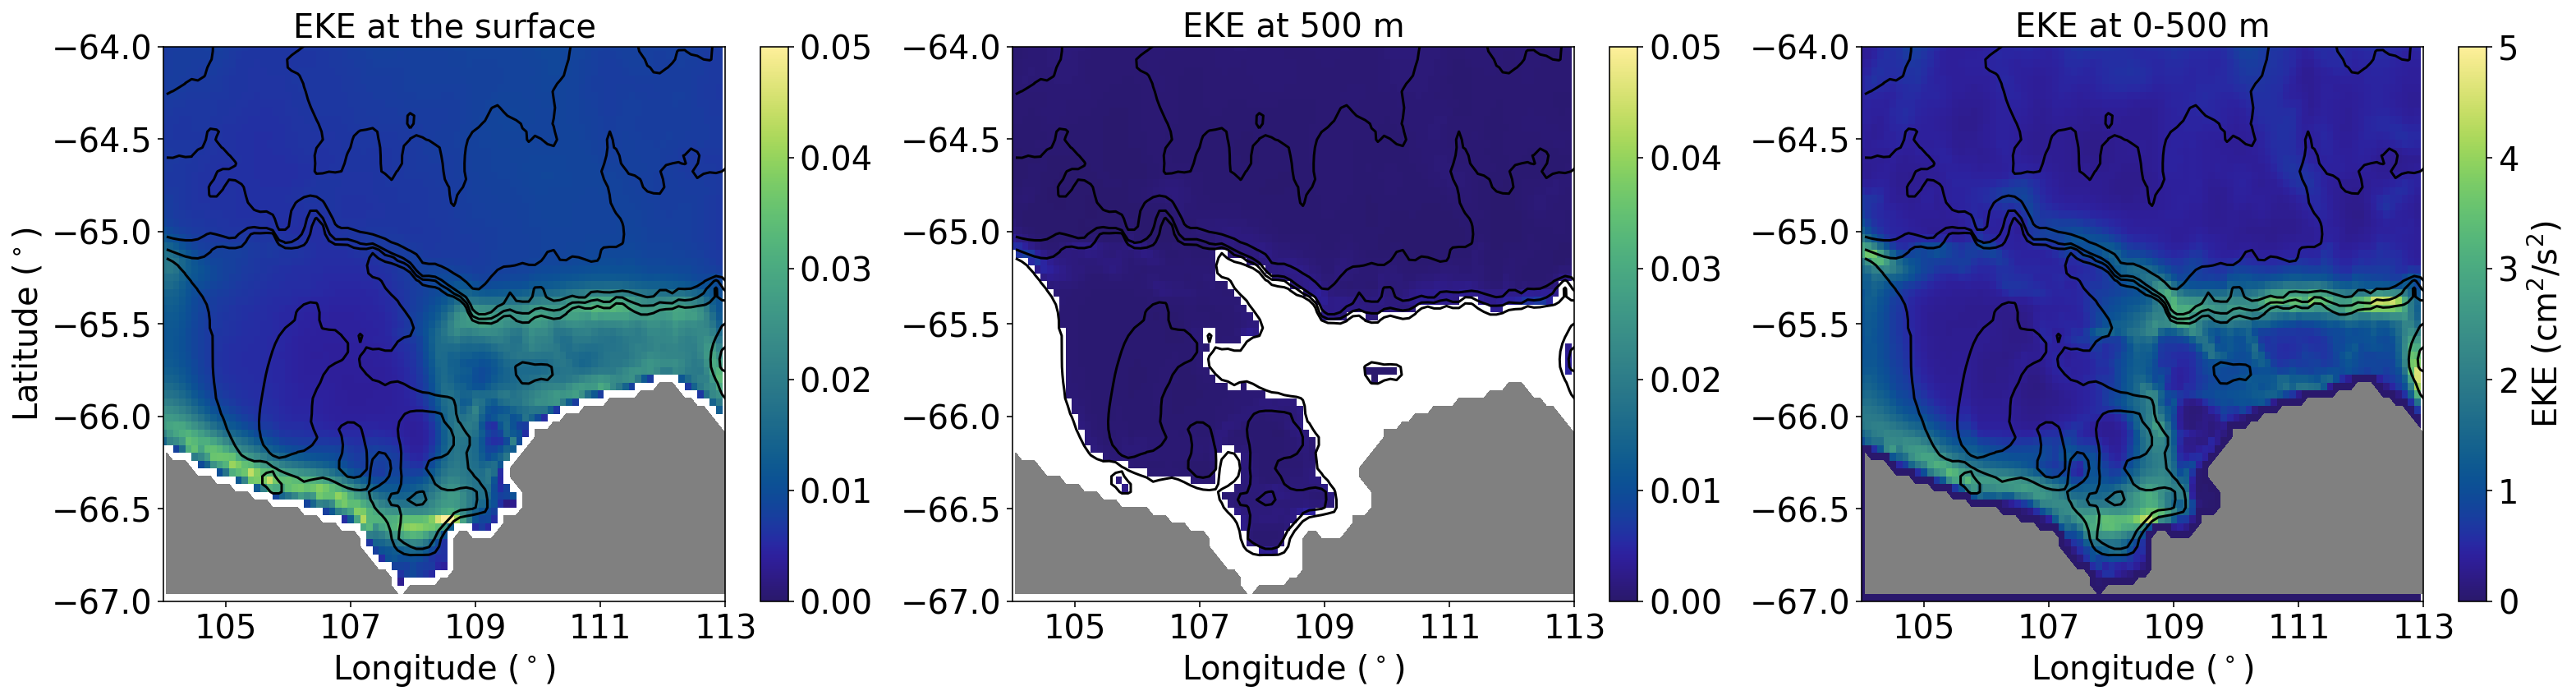

In [38]:
### test new values
fontsize=20

#for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)

ax0=plt.subplot(431) 
pc = plt.pcolormesh(EKE_surf_m.xu_ocean,EKE_surf_m.yu_ocean,
                        EKE_surf_m, cmap = cmocean.haline, 
                        vmin=0,vmax=.05)
plt.title('EKE at the surface',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='yellow',linestyle='--',linewidth=3)
# plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,2)      
pc = plt.pcolormesh(EKE_m.xu_ocean,EKE_m.yu_ocean,
                       EKE_m, cmap = cmocean.haline, 
                        vmin=0,vmax=.05)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('EKE at 500 m',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='yellow',linestyle='--',linewidth=3)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,3)      
pc = plt.pcolormesh(EKE_int_m.xu_ocean,EKE_int_m.yu_ocean,
                       EKE_int_m, cmap = cmocean.haline, 
                        vmin=0,vmax=5)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('EKE at 0-500 m',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='yellow',linestyle='--',linewidth=3)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'EKE (cm$^{2}$/s$^{2}$)', fontsize = fontsize,labelpad=5)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
filestr = figdir+'/FigSI_mean_EKE.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

#### Calculate EKE Anomalies

### Calculate the rolling mean 

In [43]:
%%time
EKE_int_total = EKE_int.compute()

CPU times: user 7min 37s, sys: 14.7 s, total: 7min 52s
Wall time: 8min 30s


In [44]:
EKE_int_roll = EKE_int_total.rolling(time=12, center=True).mean()

### loading indexes previously calculated by "Selecting_peak_low_years" code stored in /Figures/New_codes_CFD

In [45]:
outpath = '/g/data/v45/ns3783/top_index.nc'
profile_data = xr.open_dataset(outpath)
top_id = profile_data.top_id

In [46]:
outpath = '/g/data/v45/ns3783/bottom_index.nc'
profile_data = xr.open_dataset(outpath)
bt_id = profile_data.bt_id

### creating the averages for peaks and lows

In [55]:
#full mean, for those without climatology applied
EKE_int_avg = EKE_int_roll.mean('time')
EKE_int_avg = EKE_int_avg.load()

#mean of all high peaks together
EKE_high_avg=EKE_int_roll[top_id.values].mean('time')
EKE_high_avg = EKE_high_avg.load()


#mean of all low peaks together
EKE_low_avg = EKE_int_roll[bt_id.values].mean('time')
EKE_low_avg = EKE_low_avg.load()

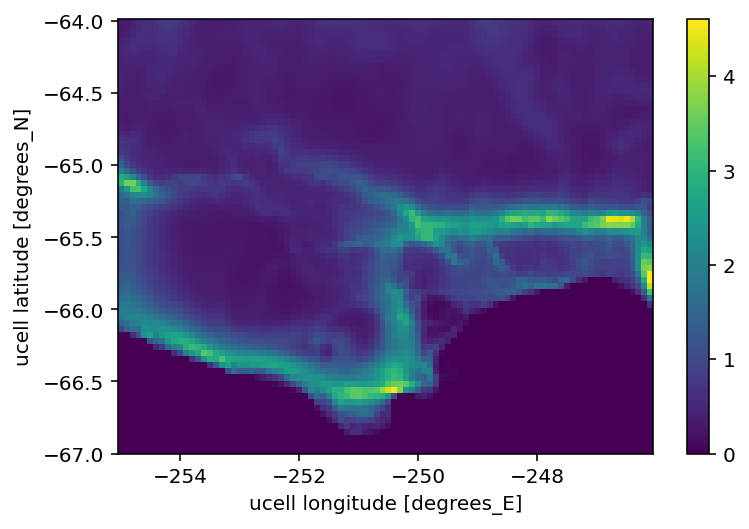

In [56]:
EKE_int_avg.plot()

## PLOT COMPOSITES FOR EKE ANOMALIES 
#### - CLIMATOLOGY ISN'T REMOVED TO AVOID NEGATIVE VALUES. ONLY ROLLING MEAN APPLIED

In [57]:
# cut the data BOX 1
lon_slice  = slice(-255, -240)
lat_slice  = slice(-67, -63)

# topography data:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)



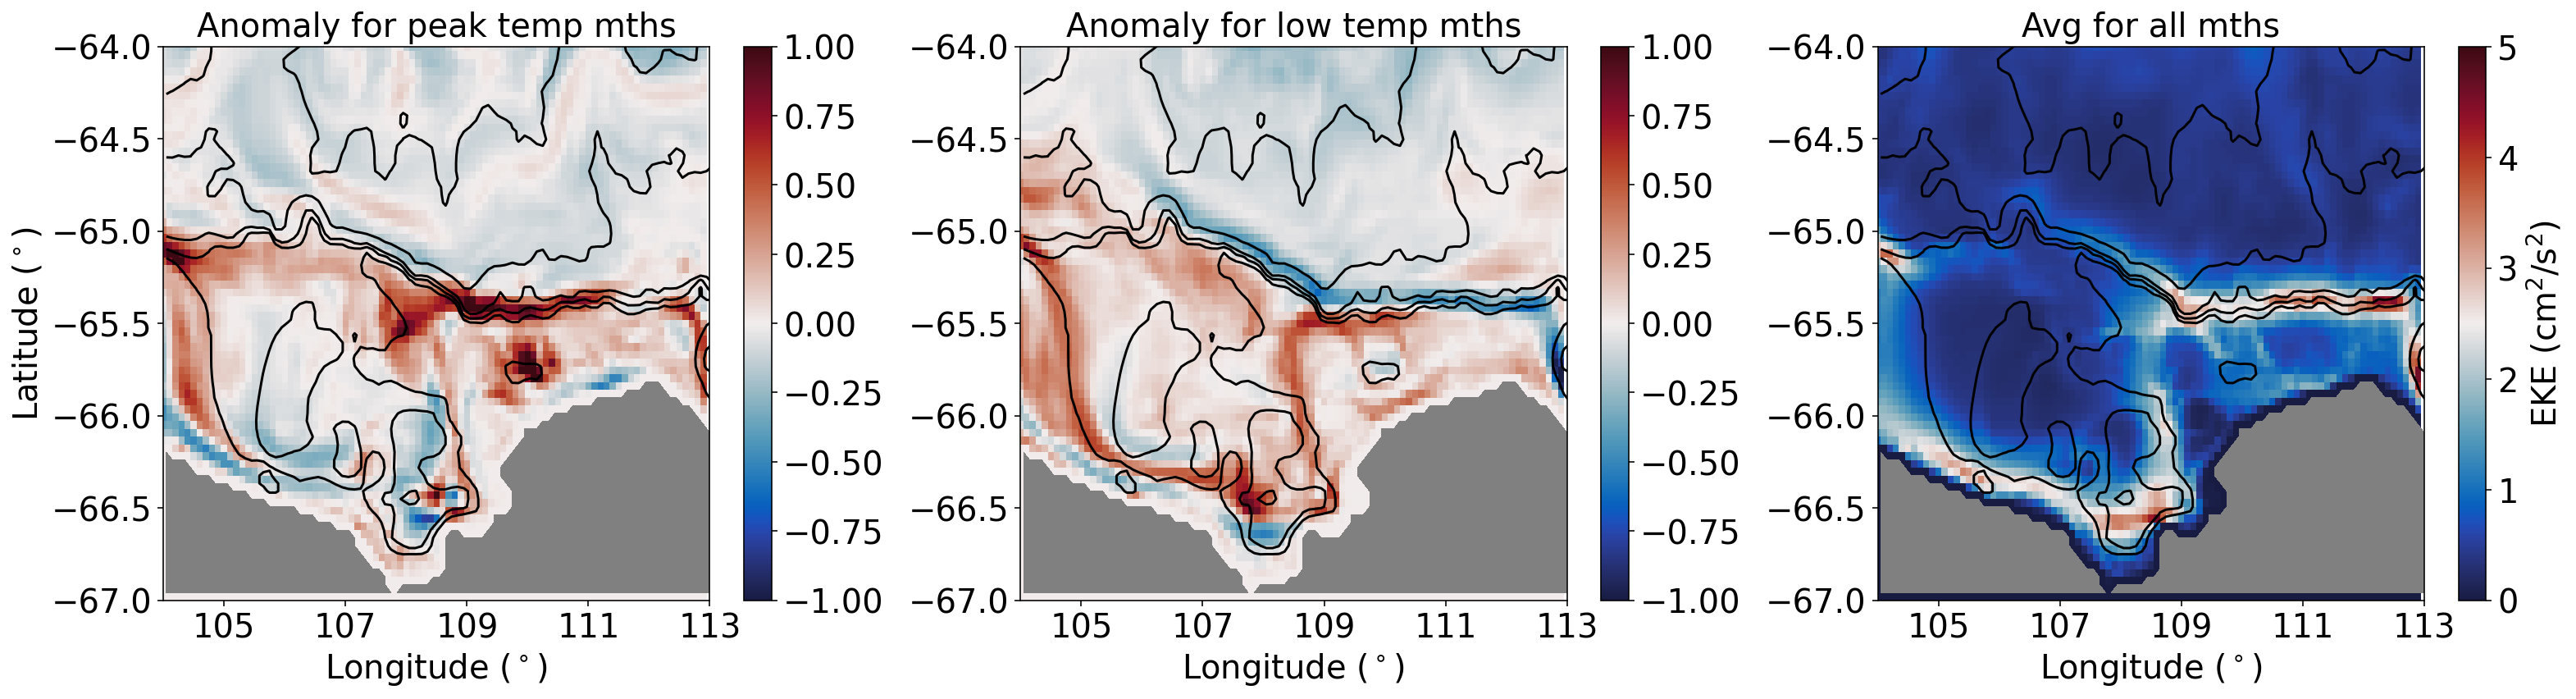

In [58]:
### test new values
fontsize=20

#for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)

t_high = EKE_high_avg-EKE_int_avg;
t_low = EKE_low_avg-EKE_int_avg;
ax0=plt.subplot(431) 
pc = plt.pcolormesh(t_high.xu_ocean,t_high.yu_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-1,vmax=1)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly for peak temp mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='yellow',linestyle='--',linewidth=3)
# plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.ax.tick_params(labelsize=fontsize)
#cbar.set_label(r'EKE (cm$^{2}$/s$^{2}$)', fontsize = fontsize,labelpad=5)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,2)      
pc = plt.pcolormesh(t_low.xu_ocean,t_low.yu_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-1,vmax=1)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly for low temp mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='yellow',linestyle='--',linewidth=3)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.ax.tick_params(labelsize=fontsize)
#cbar.set_label(r'EKE (cm$^{2}$/s$^{2}$)', fontsize = fontsize,labelpad=5)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,3)    
pc = plt.pcolormesh(EKE_int_avg.xu_ocean,EKE_int_avg.yu_ocean,
                        EKE_int_avg, cmap = cmocean.balance, 
                        vmin=0,vmax=5)
plt.title('Avg for all mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)

##TO INCLUDE THE ASC TRANSECT AND TBOX POSITIONS
#plt.plot([-252.7,-252.7],[-65.35, -65.1],color='blueviolet',linestyle='--',linewidth=5)
#plt.plot([-251.7,-251.7],[-65.35, -65.1],color='blueviolet',linestyle='--',linewidth=5)
#plt.plot([-252.7,-251.7],[-65.1, -65.1],color='blueviolet',linestyle='--',linewidth=5)
#plt.plot([-252.7,-251.7],[-65.35, -65.35],color='blueviolet',linestyle='--',linewidth=5)
#
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='blueviolet',linestyle='--',linewidth=4)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'EKE (cm$^{2}$/s$^{2}$)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
filestr = figdir+'/FigSI_eke_anomaly_just_roll.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')